In [ ]:
!pip install kmodes
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import kmodes
import matplotlib.pyplot as plt
import umap

In [ ]:
df = pd.read_csv('/content/mobile_app_user_dataset_1.csv',
                 encoding='unicode_escape', header=0, skiprows=[1], index_col=0)
df.reset_index(drop=True, inplace=True)
df = df[df['Response Status']==1] # only complete responses
apple_df = df[
    df['Q3_1_TEXT'].str.lower().str.contains('apple', na=False) |
    df['Q3_1_TEXT'].str.lower().str.contains('iphone', na=False) |
    df['Q3_2_TEXT'].str.lower().str.contains('iphone', na=False)
] # apple users
android_df = df[
    ~df['Q3_1_TEXT'].str.lower().str.contains('apple', na=False) &
    ~df['Q3_1_TEXT'].str.lower().str.contains('iphone', na=False) &
    ~df['Q3_2_TEXT'].str.lower().str.contains('iphone', na=False)
] # android users

<ipython-input-3-4d78ba80b662>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/mobile_app_user_dataset_1.csv',


In [ ]:
print('Sample size of apple users: ', len(apple_df))
print('Sample size of apple users: ', len(android_df))

Sample size of apple users:  899
Sample size of apple users:  3926


### How age influence app categories?

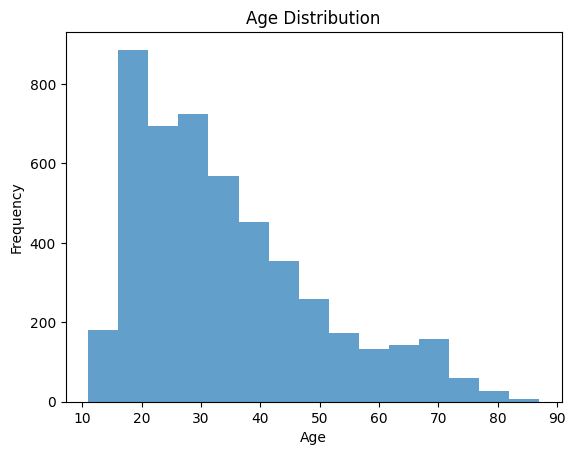

[11.  18.6 26.2 33.8 41.4 49.  56.6 64.2 71.8 79.4 87. ]


In [ ]:
cols_used = ['Q17'] + [f'Q15_{i}' for i in range(1,23)]
df_age_app = df.dropna(subset=['Q17']).reset_index()[cols_used]
df_age_app['Q17'].plot.hist(bins=15, alpha=0.7)  # bins defines number of histogram bars
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
_, bin_edges = np.histogram(df_age_app['Q17'], bins=10)
print(bin_edges)

In [ ]:
# Segment the users into 5 age groups:
df_age_app_1 = df_age_app[df_age_app['Q17'] <= 18]
df_age_app_2 = df_age_app[(df_age_app['Q17'] > 18) & (df_age_app['Q17'] <= 23)]
df_age_app_3 = df_age_app[(df_age_app['Q17'] > 23) & (df_age_app['Q17'] <= 28)]
df_age_app_4 = df_age_app[(df_age_app['Q17'] > 28) & (df_age_app['Q17'] <= 35)]
df_age_app_5 = df_age_app[(df_age_app['Q17'] > 35) & (df_age_app['Q17'] <= 45)]
df_age_app_6 = df_age_app[(df_age_app['Q17'] > 45) & (df_age_app['Q17'] <= 60)]
df_age_app_7 = df_age_app[df_age_app['Q17'] > 60]

cols_used = [f'Q15_{i}' for i in range(1,23)]
for i in range(1,8):
  df_age_app_eval = eval(f'df_age_app_{i}')
  col_sums = df_age_app_eval[cols_used].sum()/df_age_app_eval.shape[0]
  print(f'Age Group {i}:')
  top_5_cats = col_sums.sort_values(ascending=False).head(5)
  print(top_5_cats)
  print('-----------')

Age Group 1:
Q15_12    0.800866
Q15_16    0.564214
Q15_22    0.549784
Q15_6     0.457431
Q15_8     0.406926
dtype: float64
-----------
Age Group 2:
Q15_12    0.709176
Q15_16    0.674961
Q15_22    0.497667
Q15_6     0.444790
Q15_19    0.427683
dtype: float64
-----------
Age Group 3:
Q15_12    0.707989
Q15_16    0.641873
Q15_22    0.473829
Q15_19    0.447658
Q15_6     0.442149
dtype: float64
-----------
Age Group 4:
Q15_12    0.640411
Q15_16    0.623288
Q15_19    0.469178
Q15_20    0.453196
Q15_22    0.447489
dtype: float64
-----------
Age Group 5:
Q15_12    0.556330
Q15_16    0.526132
Q15_19    0.439024
Q15_20    0.422764
Q15_1     0.377468
dtype: float64
-----------
Age Group 6:
Q15_16    0.450915
Q15_12    0.424293
Q15_20    0.389351
Q15_19    0.369384
Q15_1     0.341098
dtype: float64
-----------
Age Group 7:
Q15_20    0.434988
Q15_1     0.326241
Q15_10    0.260047
Q15_19    0.255319
Q15_12    0.222222
dtype: float64
-----------


1. Generally, older people download fewer apps.
2. Games (12) and Social Networking (16) are two most popular app categories in almost every age group. Even for age >45 and <=60, 45% of people download Social networking (16) and 42% of people download games (12).
3. Music (22) is the thrid popular category and it drops out of top 5 for age groups > 35.
4. Utilities (e.g., Calculator, Alarm Clock) (19) and Weathers (20) categories rank higher as age increases.

### RFM Model (here we only focus on FM, Frequency and Monetary)

In [ ]:
drop_index = df[(df['Q11_1']==1) & ((df['Q11_2']==1) | (df['Q11_3']==1) | (df['Q11_4']==1) | (df['Q11_5']==1) | (df['Q11_6']==1) |
                                    (df['Q11_7']==1) | (df['Q11_8']==1) | (df['Q11_9']==1) | (df['Q11_10']==1))].index
df_fm = df.drop(drop_index).reset_index(drop=True)
df_fm['Q11_1'].fillna(0, inplace=True)
df_fm['Q11_1'] = df_fm['Q11_1'].astype(int)
print(df_fm.shape[0])

def frequency_tostring(x):
  if x == 1:
    return 'Never'
  elif x == 2:
    return 'Less than once a month'
  elif x == 3:
    return 'Once a month'
  elif x == 4:
    return 'More than once a month'
  elif x == 5:
    return 'Once a week'
  elif x == 6:
    return 'More than once a month '
  elif x == 7:
    return 'Once a day'
  elif x == 8:
    return 'Several times a day'
  return 'Other'

df_fm['Q5_cat'] = df_fm['Q5'].apply(frequency_tostring)
df_fm = df_fm[['Q5_cat', 'Q11_1']]
df_fm.groupby(['Q5_cat', 'Q11_1']).size()

4500


<ipython-input-5-6a0c9201bf5d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fm['Q11_1'].fillna(0, inplace=True)


Q5_cat                   Q11_1
Less than once a month   0        264
                         1        542
More than once a month   0        258
                         1        282
More than once a month   0        473
                         1        381
Never                    0         94
                         1        318
Once a day               0        271
                         1        171
Once a month             0        233
                         1        307
Once a week              0        266
                         1        282
Other                    0          8
                         1         13
Several times a day      0        231
                         1        106
dtype: int64

There's a positive relationship between frequency of visiting app store and spending money on apps. People who often visit the app store tend to spend money on apps. Implication for app companies is that they can place more ads targeting users who visit app store frequently.

In [ ]:
# A/B test for game download
apple_games_df = apple_df[apple_df['Q15_12']==1]
games_ratio_apple = len(apple_games_df) / len(apple_df)
print('Number and Ratio of apple users who download games: ', len(apple_games_df), ', ', games_ratio_apple)

android_games_df = android_df[android_df['Q15_12']==1]
games_ratio_android = len(android_games_df) / len(android_df)
print('Number and Ratio of android users who download games: ', len(android_games_df), ', ', games_ratio_android)

Number and Ratio of apple users who download games:  619 ,  0.6885428253615128
Number and Ratio of android users who download games:  2295 ,  0.5845644421803362


In [ ]:
count = np.array([619, 2295])
nobs = np.array([899, 3926])

stat, pval = sm.stats.proportions_ztest(count, nobs) # perform Two-proportion Z test package
print(stat, pval)

5.7500496558403364 8.921724205172475e-09


#### p-value is 8.9e-09 < 0.05, we reject the null hypothesis that the percentages of people downloading games for apple users and android users are the same.

In [ ]:
# A/B test for download considering reviews by other users
apple_review_df = apple_df[apple_df['Q9_1']==1]
review_ratio_apple = len(apple_review_df) / len(apple_df)
print('Number and Ratio of apple users who consider reviews: ', len(apple_review_df), ', ', review_ratio_apple)

android_review_df = android_df[android_df['Q9_1']==1]
review_ratio_android = len(android_review_df) / len(android_df)
print('Number and Ratio of android users who consider reviews: ', len(android_review_df), ', ', review_ratio_android)

Number and Ratio of apple users who consider reviews:  459 ,  0.5105672969966629
Number and Ratio of android users who consider reviews:  1862 ,  0.47427407030056035


In [ ]:
count = np.array([459, 1862])
nobs = np.array([899, 3926])

stat, pval = sm.stats.proportions_ztest(count, nobs) # perform Two-proportion Z test package
print(stat, pval)

1.9646016355674778 0.04946036253038866


#### p-value is 0.049 < 0.05, we marginally reject the null hypothesis that the percentages of people who consider reviews when download apps for apple users and android users are the same.

In [ ]:
# Customer Profile Segmentation / Clustering using K-Prototype
df = df[['Do you use apps? (based on all app related questions)',
         'Q5', 'Q6', 'Q17', 'Q18', 'Q22', 'Q23', 'Q26']]
df.rename(columns={'Do you use apps? (based on all app related questions)': 'use_app'}, inplace=True)
df.dropna(axis=0, inplace=True)
print('Number of observations: ', len(df))
print(df['Q5'].mode())

Number of observations:  4823
0    6.0
Name: Q5, dtype: float64


<ipython-input-4-840901a3139b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Do you use apps? (based on all app related questions)': 'use_app'}, inplace=True)
<ipython-input-4-840901a3139b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


In [ ]:
def use_app_transform(x):
  if x == 1:
    return "Yes"
  else:
    return "No"

def q5_transform(x):
  if x == 1:
    return 0
  elif x == 2:
    return 0.5
  elif x == 3:
    return 1
  elif x == 4:
    return 2.5
  elif x == 5:
    return 4
  elif x == 6:
    return 10
  elif x == 7:
    return 30
  elif x == 8:
    return 60
  return 10

def q5_transform(x):
  if x == 1:
    return 0
  elif x == 2:
    return 0.5
  elif x == 3:
    return 1
  elif x == 4:
    return 2.5
  elif x == 5:
    return 4
  elif x == 6:
    return 10
  elif x == 7:
    return 30
  elif x == 8:
    return 60
  return 10

def q6_transform(x):
  if x == 1:
    return 0.5
  elif x == 2:
    return 2.5
  elif x == 3:
    return 8
  elif x == 4:
    return 15
  elif x == 5:
    return 25
  return 35

def q18_transform(x):
  if x == 1:
    return "In a relationship"
  elif x == 2:
    return "Single"
  elif x == 3:
    return "Married"
  elif x == 4:
    return "Divorced"
  elif x == 5:
    return "Widowed"
  elif x == 6:
    return "Separated"
  return "Other (please specify)"

def q22_transform(x):
  if x == 1:
    return "Asian"
  elif x == 2:
    return "Black"
  elif x == 3:
    return "Hispanic"
  elif x == 4:
    return "White"
  elif x == 5:
    return "Mixed"
  elif x == 6:
    return "Other"
  return "Prefer not to say"

def q23_transform(x):
  if x == 1:
    return "Primary school"
  elif x == 2:
    return "Secondary / High school"
  elif x == 3:
    return "Diploma"
  elif x == 4:
    return "Vocational training"
  elif x == 5:
    return "Undergraduate degree"
  elif x == 6:
    return "Master's degree"
  elif x == 7:
    return "Doctoral degree"
  return "Other"

def q26_transform(x):
  if x == 1:
    return "Full-time"
  elif x == 2:
    return "Part-time"
  elif x == 3:
    return "Self-employed"
  elif x == 4:
    return "Student"
  elif x == 5:
    return "Homemaker"
  elif x == 6:
    return "Unemployed"
  elif x == 7:
    return "Unable to work"
  elif x == 8:
    return "Retired"
  return "Other"

df['use_app'] = df['use_app'].apply(use_app_transform)
df['Q5'] = df['Q5'].apply(q5_transform)
df['Q6'] = df['Q6'].apply(q6_transform)
df['Q18'] = df['Q18'].apply(q18_transform)
df['Q22'] = df['Q22'].apply(q22_transform)
df['Q23'] = df['Q23'].apply(q23_transform)
df['Q26'] = df['Q26'].apply(q26_transform)

<ipython-input-5-1b1811f628a0>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['use_app'] = df['use_app'].apply(use_app_transform)
<ipython-input-5-1b1811f628a0>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Q5'] = df['Q5'].apply(q5_transform)
<ipython-input-5-1b1811f628a0>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(df[['Q5', 'Q6', 'Q17']])
df[['Q5', 'Q6', 'Q17']] = scaled_X

<ipython-input-6-394f54cb1c1d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Q5', 'Q6', 'Q17']] = scaled_X


In [ ]:
from kmodes.kprototypes import KPrototypes

categorical_cols = [0, 4, 5, 6, 7]
kproto = KPrototypes(n_clusters=3, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=3')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=3
[['0.06353691019786903' '0.06202986786667391' '0.42196937835456333' 'Yes'
  'Married' 'White' 'Undergraduate degree' 'Full-time']
 ['0.11602400679838543' '0.09056816397409861' '0.1487747811210622' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.7843450479233246' '0.42399407325091437' '0.23936438540440488' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']]
1339.7667454679504


In [ ]:
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=4')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=4
[['0.0860161870503578' '0.0858878114899367' '0.3391246213555469' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.12030346820809197' '0.08921839658205406' '0.13431225281411685' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.8023124647490132' '0.44196767944284904' '0.2382447234838365' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.059735023041474884' '0.052043678621518034' '0.4541520130972618'
  'Yes' 'Married' 'White' 'Diploma' 'Full-time']]
1236.9147357371667


In [ ]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=5')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=5
[['0.849577647823256' '0.46526541797327536' '0.23727813686262317' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.12449379903821825' '0.08868420763042822' '0.12750769292251143' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.03601838413159151' '0.03592688416314271' '0.6584867466198151' 'Yes'
  'Married' 'White' 'Secondary / High school' 'Retired']
 ['0.06534155814484821' '0.05607374516990959' '0.34647920349193734' 'Yes'
  'Married' 'White' 'Diploma' 'Full-time']
 ['0.14210059171597675' '0.12839379127004488' '0.2879803799439421' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']]
1155.12109477363


In [ ]:
kproto = KPrototypes(n_clusters=6, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=6')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=6
[['0.09201208981001771' '0.10352181422242165' '0.3075961276247621' 'Yes'
  'Married' 'White' 'Undergraduate degree' 'Full-time']
 ['0.1352923716236245' '0.10254623356175811' '0.12142639546328002' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.056409564904710274' '0.04405672029141881' '0.4512008175779249' 'Yes'
  'Married' 'White' 'Diploma' 'Full-time']
 ['0.07433747412008343' '0.06020343865334299' '0.2415168355671793' 'Yes'
  'Single' 'White' 'Diploma' 'Full-time']
 ['0.03555155875299744' '0.03458103082751116' '0.7323614792376608' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Retired']
 ['0.8060295790671211' '0.4296136914477904' '0.24050206574456573' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']]
1130.7837231130873


In [ ]:
kproto = KPrototypes(n_clusters=7, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=7')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=7
[['0.42440843621399427' '0.44207371622830555' '0.28167641325536014' 'Yes'
  'Married' 'White' 'Undergraduate degree' 'Full-time']
 ['0.037561728395061604' '0.031597781356235505' '0.6108187134502933'
  'Yes' 'Married' 'White' 'Secondary / High school' 'Retired']
 ['0.06919451585261306' '0.05256883126560049' '0.22936679745636643' 'Yes'
  'In a relationship' 'Prefer not to say' 'Diploma' 'Part-time']
 ['0.05790709812108438' '0.05008925599830492' '0.3046093835842228' 'Yes'
  'Single' 'White' 'Diploma' 'Full-time']
 ['0.08620629975770246' '0.08427769500504023' '0.3423525714598027' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.14225663716814058' '0.10040898921237515' '0.11014723386637772' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.9999999999999996' '0.41436464088397923' '0.23048124454783317' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']]
1101.1090976141675


In [ ]:
kproto = KPrototypes(n_clusters=8, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=8')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=8
[['0.058691939890709796' '0.05056129722024244' '0.4085553278688506' 'Yes'
  'Married' 'White' 'Undergraduate degree' 'Full-time']
 ['0.1210412508316699' '0.0789435621510595' '0.11444873411072562' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.07107142857142906' '0.06455486542443073' '0.24131578947368484' 'Yes'
  'In a relationship' 'Prefer not to say' 'Diploma' 'Part-time']
 ['0.0428092626447287' '0.03476141271229111' '0.6910179928798219' 'Yes'
  'Married' 'White' 'Diploma' 'Retired']
 ['0.999999999999997' '0.4143646408839783' '0.2304812445478326' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.43169590643274863' '0.5030765319094848' '0.2259926131117267' 'Yes'
  'Single' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.13520092735703215' '0.11408283493492714' '0.27778207109737285' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.06215596330275416' '0.05090191907104448' '0.2886286817962337' 'Yes'
  'In a relationship' '

In [ ]:
kproto = KPrototypes(n_clusters=9, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=9')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=9
[['0.7342272202998846' '0.6850709593300245' '0.25919686760152977' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.13892805495300042' '0.10003458140777763' '0.10906638885717373' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.10586956521739142' '0.08972904851921862' '0.22540045766590375' 'Yes'
  'In a relationship' 'Prefer not to say' 'Diploma' 'Part-time']
 ['0.07700934579439254' '0.06284708113233035' '0.23748155435317306' 'Yes'
  'Single' 'White' 'Diploma' 'Full-time']
 ['0.06436781609195398' '0.050867423431141784' '0.4202748249935189' 'Yes'
  'Married' 'White' 'Diploma' 'Full-time']
 ['0.9182879377431858' '0.215248406924943' '0.20965594921155045' 'Yes'
  'Single' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.12862068965517254' '0.11590204897551121' '0.30203448275862055' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.06497005988023963' '0.053458300789724925' '0.28732009664880687'
  'Yes' 'In a relationship' 'White

In [ ]:
kproto = KPrototypes(n_clusters=10, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
print('#cluster=10')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=10
[['0.07057405784399737' '0.07344180670400907' '0.38069214447160915' 'Yes'
  'Married' 'White' 'Undergraduate degree' 'Full-time']
 ['0.0725571315996856' '0.08841264946722781' '0.11788447181784258' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.0835069444444445' '0.08137077294685995' '0.25294682017543835' 'Yes'
  'In a relationship' 'Prefer not to say' 'Diploma' 'Part-time']
 ['0.1280586766541823' '0.11871030776746441' '0.2637492607924301' 'Yes'
  'Single' 'White' 'Diploma' 'Unemployed']
 ['0.7593167701863368' '0.2547934107480428' '0.2922115070284404' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.6688741721854313' '0.2192628851137342' '0.12303938654583574' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.056296615031555' '0.05131083339569457' '0.2937992571790919' 'Yes'
  'In a relationship' 'White' 'Diploma' 'Full-time']
 ['0.7392998027613412' '0.855930023154102' '0.24704142011834299' 'Yes'
  'Married' 'Asian' 'Under

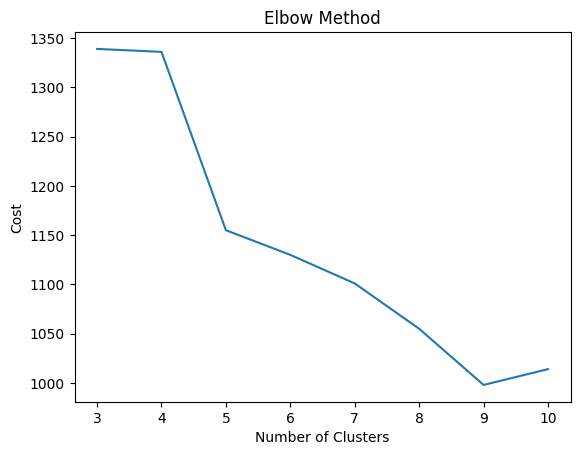

In [ ]:
# Use Elbow Method to determine the number of clusters
n_clusters = np.arange(3, 11)
costs = np.array([1339,1336,1155,1130,1101,1055,998, 1014])
plt.plot(n_clusters, costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()

#### According to the Elbow Method, we should choose n_clusters=5

In [ ]:
from kmodes.kprototypes import KPrototypes

categorical_cols = [0, 4, 5, 6, 7]
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=0)
clusters = kproto.fit_predict(df, categorical=categorical_cols)
centroids = kproto.cluster_centroids_
labels = kproto.labels_
print('#cluster=5')
print(kproto.cluster_centroids_)
print(kproto.cost_)

#cluster=5
[['0.7845639032815181' '0.5500488097919957' '0.2735546768475595' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']
 ['0.06720753205128258' '0.07853725380899218' '0.14151589912280782' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.0616253364090736' '0.056015244972668715' '0.38559309172585354' 'Yes'
  'Married' 'White' 'Diploma' 'Full-time']
 ['0.6731770833333339' '0.20361564009661823' '0.1509388706140355' 'Yes'
  'Single' 'Asian' 'Secondary / High school' 'Student']
 ['0.08211173358232245' '0.07925682350234722' '0.4513747604304883' 'Yes'
  'Married' 'Asian' 'Undergraduate degree' 'Full-time']]
1185.3606132491375


In [ ]:
# UMAP Dimension Reduction
#Preprocessing numerical
numerical = df.select_dtypes(exclude='object')

#for c in numerical.columns:
#    pt = PowerTransformer()
#    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))

##preprocessing categorical
categorical = df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
#embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components,
#                                                fit1._initial_alpha, fit1._a, fit1._b,
#                                                fit1.repulsion_strength, fit1.negative_sample_rate,
#                                                200, 'random', np.random, fit1.metric,
#                                                fit1._metric_kwds, False)
embedding = umap.umap_.simplicial_set_embedding(
    fit1._raw_data,
    intersection,
    fit1.n_components,
    fit1._initial_alpha,
    fit1._a,
    fit1._b,
    fit1.repulsion_strength,
    fit1.negative_sample_rate,
    200,
    'random',
    np.random,
    fit1.metric,
    fit1._metric_kwds,
    False,  # DensMAP disabled
    None,   # No densmap_kwds needed
    False   # No output density
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


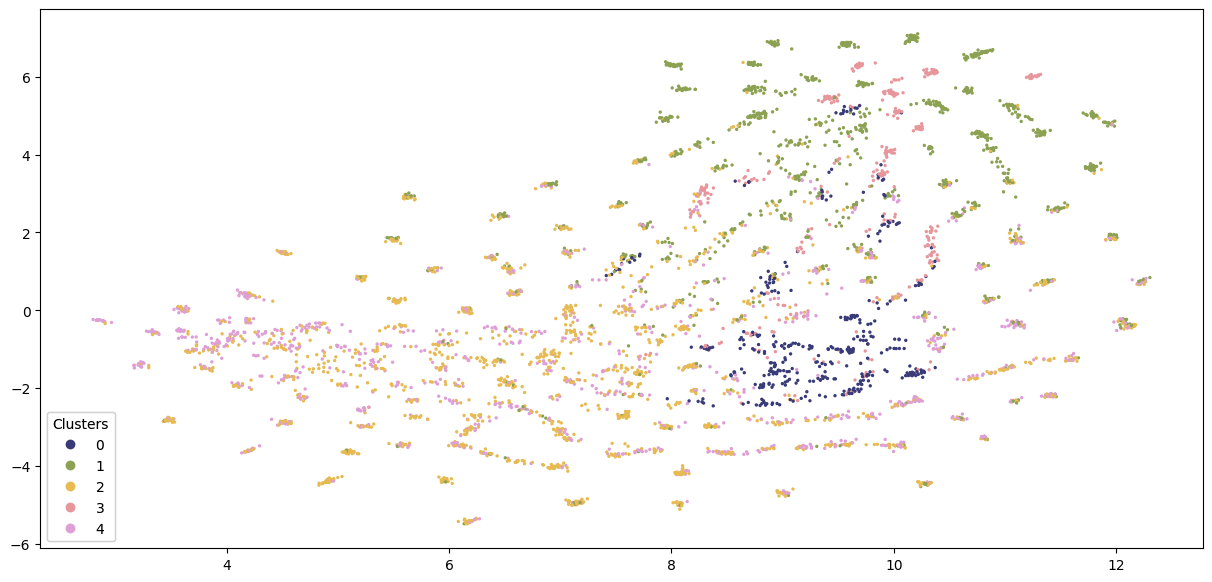

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 7))
scatter = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=2, c=labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=4),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

In [21]:
df = pd.read_csv('/content/mobile_app_user_dataset_1.csv',
                 encoding='unicode_escape', header=0, skiprows=[1], index_col=0)
df.reset_index(drop=True, inplace=True)
df = df[df['Response Status']==1]
df = df[['Do you use apps? (based on all app related questions)',
         'Q5', 'Q6', 'Q17', 'Q18', 'Q22', 'Q23', 'Q26']]
df.rename(columns={'Do you use apps? (based on all app related questions)': 'use_app'}, inplace=True)
df.dropna(axis=0, inplace=True)

# For frequency and education level variable, simply use ordinal encoding. For race, martial status, and employment status, do one-hot encoding.
df_dummies = pd.get_dummies(df, columns=['Q18', 'Q22', 'Q26'], drop_first=False).astype(int)
df.drop(['Q18', 'Q22', 'Q26'], axis=1, inplace=True)
df = pd.concat([df, df_dummies], axis=1)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

<ipython-input-21-df6eb53b7731>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/mobile_app_user_dataset_1.csv',


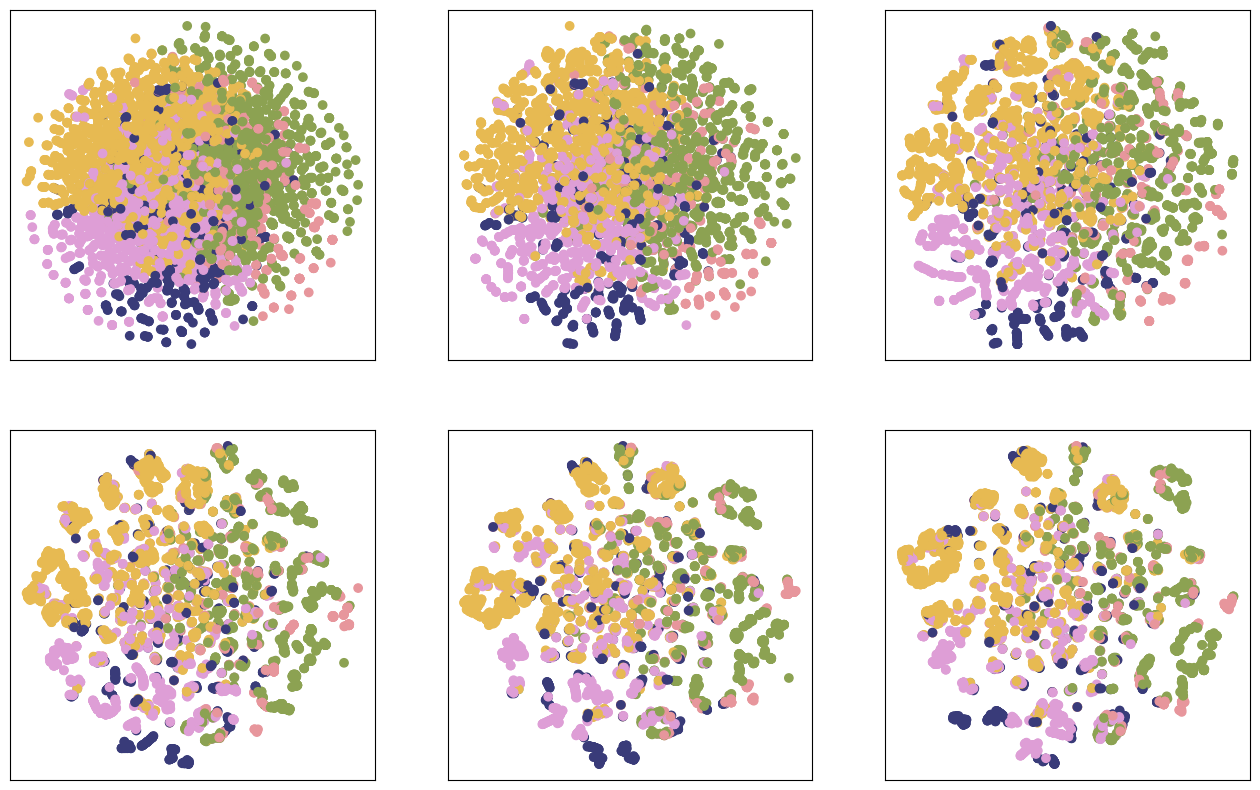

In [26]:
from sklearn.manifold import TSNE

# Experiment with different perplexity:
fig, ax = plt.subplots(2, 3, figsize=(16, 10), subplot_kw=dict(xticks=[], yticks=[]))
perplexities = [2, 3, 5, 10, 15, 20]
for i, axi in enumerate(ax.flat):
  perplexity = perplexities[i]
  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  tsne_results = tsne.fit_transform(df_scaled)
  axi.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab20b')

In [ ]:
# Profile Visualization / Analysis
centroids_num = centroids[:, 0:3]
centroids_num = scaler.inverse_transform(centroids_num)
centroids_cat = centroids[:, 3:]
unique, counts = np.unique(labels, return_counts=True)
centroids_show = np.concatenate((centroids_num, centroids_cat, counts.reshape((5,1))), axis=1)
centroids_df = pd.DataFrame(centroids_show, columns=['monthly_visit_frequency', 'monthly_download_frequency', 'age', 'use_app', 'Status', 'Ethnicity', 'Education', 'Job', 'num_of_points'])
centroids_df.head()

,monthly_visit_frequency,monthly_download_frequency,age,use_app,Status,Ethnicity,Education,Job,num_of_points
0,4.296463245492373,3.051317614424346,38.6685852981969,Yes,Married,White,Undergraduate degree,Full-time,1442
1,7.505725190839684,3.809541984732799,21.19045801526712,Yes,Single,Asian,Secondary / High school,Student,1310
2,4.955898566703396,2.9603087100330545,31.561190738699043,Yes,In a relationship,White,Diploma,Full-time,907
3,48.016806722689026,15.292436974789945,29.309243697479015,Yes,Married,Asian,Undergraduate degree,Full-time,595
4,2.2987697715289936,1.6177504393673126,64.80843585237261,Yes,Married,White,Undergraduate degree,Retired,569
